In [1]:
from sklearn.cluster import KMeans, k_means, Birch, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import _tree, DecisionTreeClassifier
from scipy.spatial.distance import cdist
pd.set_option('display.max_columns', None)

# Hypothesis
I am setting out to use unsupervised learning, particularly clustering methods, to examine and categorize exoplanets into groups that could offer unique insights to astronomers.

## Initial read-in and scaling.

In [2]:
df = pd.read_csv('../datasets/clean_planetary_data.csv')

In [3]:
df.head()

,Unnamed: 0,pl_name,hostname,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt
0,0,11 Com b,11 Com,Xinglong Station,326.03000,1.29,12.1,6165.6000,0.231,98.09,1700.0
1,1,11 UMi b,11 UMi,Thueringer Landessternwarte Tautenburg,516.21997,1.53,12.3,4684.8142,0.080,98.09,1700.0
2,2,14 And b,14 And,Okayama Astrophysical Observatory,185.84000,0.83,12.9,1525.5000,0.000,98.09,1700.0
3,3,14 Her b,14 Her,W. M. Keck Observatory,1773.40002,2.93,12.9,1481.0878,0.370,98.09,1700.0
4,4,16 Cyg B b,16 Cyg B,Multiple Observatories,798.50000,1.66,13.5,565.7374,0.680,98.09,1700.0


In [4]:
df = df.drop(columns = 'Unnamed: 0')

In [5]:
ss = StandardScaler()
df_scaled = ss.fit_transform(df.drop(columns = ['pl_name','hostname','disc_facility']))

## First model, BIRCH

In [6]:
#The first model I will attempt will be a BIRCH model.
birch_model = Birch()

In [7]:
birch_model.fit(df_scaled)

Birch()

In [8]:
df['birch_labels'] = birch_model.labels_

df['birch_labels'].value_counts()

0    4340
1       4
2       1
Name: birch_labels, dtype: int64

In [9]:
birch_score = silhouette_score(df_scaled, birch_model.labels_, metric='euclidean')
birch_score
#As far as silhouette scores go, this is remarkably high.  However, almost the entire dataset is grouped
#into one category.  That is unacceptable.

0.9134106622844791

In [10]:
df.head()

,pl_name,hostname,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,birch_labels
0,11 Com b,11 Com,Xinglong Station,326.03000,1.29,12.1,6165.6000,0.231,98.09,1700.0,0
1,11 UMi b,11 UMi,Thueringer Landessternwarte Tautenburg,516.21997,1.53,12.3,4684.8142,0.080,98.09,1700.0,0
2,14 And b,14 And,Okayama Astrophysical Observatory,185.84000,0.83,12.9,1525.5000,0.000,98.09,1700.0,0
3,14 Her b,14 Her,W. M. Keck Observatory,1773.40002,2.93,12.9,1481.0878,0.370,98.09,1700.0,0
4,16 Cyg B b,16 Cyg B,Multiple Observatories,798.50000,1.66,13.5,565.7374,0.680,98.09,1700.0,0


The BIRCH model failed to provide an easy solution to my problem.  I will try a DBSCAN model instead, and perhaps using a manual grid search will provide more results.

In [11]:
df = df.drop(columns = 'birch_labels')

In [12]:
#this cell may run over 30 seconds.
best_min = 0
best_score = 0.0
for n in range(5,300, 5):
    model = DBSCAN(min_samples = n, n_jobs = -1)
    model.fit(df_scaled)
    score = silhouette_score(df_scaled, model.labels_, metric = 'euclidean')
    if score > best_score:
        best_score = score
        best_min = n
    else:
        pass
print(best_score)
print(' ')
print(best_min)

0.45959648348192295
 
15


[-1  0]


<AxesSubplot:ylabel='Frequency'>

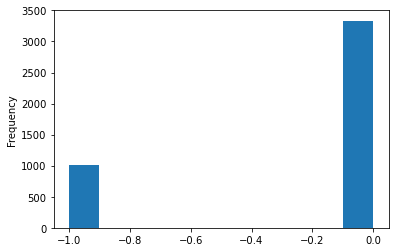

In [13]:
db_model = DBSCAN(min_samples = 15, n_jobs = -1)
db_model.fit(df_scaled)
df['dbs_labels'] = db_model.labels_
print(df['dbs_labels'].unique())
df['dbs_labels'].plot(kind = 'hist')
#I don't think DBScan is doing me any good either here.  

It would appear that a huge part of the dataset is listed by DBSCAN into on single cluster, and the rest is marked as -1, or 'noisy'.  This is quite unhelpful.

In [14]:
df = df.drop(columns = 'dbs_labels')

In [19]:
#elbow code from https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(df_scaled)
    kmeanModel.fit(df_scaled)
    distortions.append(sum(np.min(cdist(df_scaled, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / df_scaled.shape[0])
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(cdist(df_scaled, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / df_scaled.shape[0]
    mapping2[k] = kmeanModel.inertia_

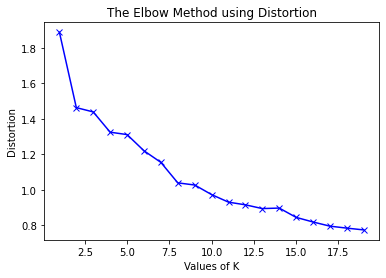

In [20]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

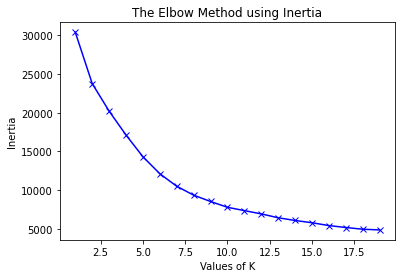

In [21]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Between the k-means gridsearch, the Distortion elbow method, and the Inertia elbow method, it appears that a K-means 'n_clusters' parameter of 7 will perform the best.

In [22]:
model = KMeans(n_clusters= 7, random_state= 42)
model.fit(df_scaled)
df['k_labels'] = model.labels_


In [23]:
df.k_labels.value_counts()

1    2894
3     771
0     357
4     207
5     111
6       4
2       1
Name: k_labels, dtype: int64

This is the best I've gotten.  A few outlier planets that refuse to be incorporated, and the '1' cluster is very large.  But, maybe there's still some truth to this.  I'll examine these clusters to see what separates them all from one another.  If it's meaningful, then I can reject my null hypothesis ('ML Clustering cannot find meaningful new categories that were unknown beforehand').  If the clusters are meaningless, then I fail to reject my null hypothesis.

In [24]:
df.head()

,pl_name,hostname,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
0,11 Com b,11 Com,Xinglong Station,326.03000,1.29,12.1,6165.6000,0.231,98.09,1700.0,6
1,11 UMi b,11 UMi,Thueringer Landessternwarte Tautenburg,516.21997,1.53,12.3,4684.8142,0.080,98.09,1700.0,6
2,14 And b,14 And,Okayama Astrophysical Observatory,185.84000,0.83,12.9,1525.5000,0.000,98.09,1700.0,0
3,14 Her b,14 Her,W. M. Keck Observatory,1773.40002,2.93,12.9,1481.0878,0.370,98.09,1700.0,2
4,16 Cyg B b,16 Cyg B,Multiple Observatories,798.50000,1.66,13.5,565.7374,0.680,98.09,1700.0,2


# Exploration and summaries of every cluster

In [25]:
cluster_0 = df[df['k_labels'] == 0]
cluster_1 = df[df['k_labels'] == 1]
cluster_2 = df[df['k_labels'] == 2]
cluster_3 = df[df['k_labels'] == 3]
cluster_4 = df[df['k_labels'] == 4]
cluster_5 = df[df['k_labels'] == 5]
cluster_6 = df[df['k_labels'] == 6]

In [26]:
cluster_0.head()

,pl_name,hostname,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
2,14 And b,14 And,Okayama Astrophysical Observatory,185.8400,0.830,12.9,1525.5000,0.000,98.09,1700.0,0
5,18 Del b,18 Del,Okayama Astrophysical Observatory,993.3000,2.600,12.5,3273.5000,0.080,98.09,1700.0,0
7,24 Boo b,24 Boo,Okayama Astrophysical Observatory,30.3506,0.190,13.9,289.2253,0.042,98.09,1600.0,0
8,24 Sex b,24 Sex,Lick Observatory,452.8000,1.333,13.4,632.4600,0.090,98.09,1600.0,0
9,24 Sex c,24 Sex,Lick Observatory,883.0000,2.080,13.9,273.3200,0.290,98.09,1600.0,0


In [27]:
cluster_0.describe()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
count,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.000000,772.0
mean,535.147715,1.795433,13.329605,579.528946,0.066024,445.882241,1278.321244,0.0
std,1334.586309,13.217386,2.600201,633.388038,0.076148,524.379048,486.518874,0.0
min,0.090706,0.004400,2.500000,1.980000,0.000000,0.160000,55.000000,0.0
25%,3.330775,0.044667,12.500000,187.519700,0.000000,98.090000,900.000000,0.0
50%,6.340555,0.069500,13.400000,351.190000,0.040000,161.670000,1270.000000,0.0
75%,464.400000,1.264250,14.100000,723.572625,0.112500,661.000000,1626.000000,0.0
max,16510.000000,320.000000,23.371000,3314.820000,0.312000,2340.000000,2782.000000,0.0


Especially hot average temperature as measured by equilibrium temp, but not so hot in insolation flux.  The second smallest in planet size, but very dense.  In summary, small, dense, hot planets, with mostly long orbital periods.  As far as small, dense, hot planets, that sounds a lot like Mercury or Venus, although even these planets are 12 times larger than Earth, on average.  However, this cluster is incredibly small.

In [28]:
cluster_1.head()

,pl_name,hostname,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
29,55 Cnc e,55 Cnc,McDonald Observatory,0.736547,0.015440,1.875,7.9900,0.05,98.09,1958.0,1
30,55 Cnc f,55 Cnc,Multiple Observatories,259.880000,0.770800,7.590,44.8120,0.08,98.09,546.0,1
32,61 Vir b,61 Vir,Multiple Observatories,4.215000,0.050201,2.110,5.1000,0.12,98.09,546.0,1
33,61 Vir c,61 Vir,Multiple Observatories,38.021000,0.217500,4.460,18.2000,0.14,98.09,546.0,1
43,AU Mic b,AU Mic,Transiting Exoplanet Survey Satellite (TESS),8.463210,0.066000,4.203,57.2094,0.10,98.09,546.0,1


In [29]:
cluster_1.describe()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
count,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.0
mean,54.994124,0.177961,2.490597,19.584403,0.026221,168.931351,775.586731,1.0
std,365.103116,0.466857,1.532447,129.844958,0.060669,258.169720,325.257739,0.0
min,0.179715,0.005800,0.296000,0.020000,0.000000,0.070000,50.000000,1.0
25%,5.606363,0.058050,1.530000,3.082500,0.000000,16.237500,529.000000,1.0
50%,11.740961,0.097000,2.180000,5.690000,0.000000,67.830000,742.500000,1.0
75%,25.957053,0.168725,2.860000,9.320000,0.000000,196.700000,972.000000,1.0
max,10140.000000,15.000000,12.450000,3308.410000,0.350000,2144.310000,2271.000000,1.0


These planets have generally shorter orbital periods, smaller radii, and much less dense.  Additionally, this is the most populous cluster.  These sound almost like Uranus or Neptune-like planets, except that they are much, much smaller (Uranus is the smallest outer planet in our system, and it is still 12 times the size of earth.)

In [30]:
cluster_2.head()

,pl_name,hostname,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
3,14 Her b,14 Her,W. M. Keck Observatory,1773.40002,2.93,12.9,1481.0878,0.370,98.09,1700.0,2
4,16 Cyg B b,16 Cyg B,Multiple Observatories,798.50000,1.66,13.5,565.7374,0.680,98.09,1700.0,2
13,2MASS J04414489+2301513 b,2MASS J04414489+2301513,Hubble Space Telescope,416.00000,15.00,12.6,2383.6000,0.260,98.09,1150.0,2
14,2MASS J12073346-3932539 b,2MASS J12073346-3932539,Paranal Observatory,416.00000,46.00,13.0,1271.0000,0.260,98.09,1150.0,2
19,4 UMa b,4 UMa,Thueringer Landessternwarte Tautenburg,269.30000,0.87,12.7,2256.5000,0.432,98.09,700.0,2


In [31]:
cluster_2.describe()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.0
mean,1104.593125,1.893900,11.366161,797.724649,0.431996,215.341634,833.112676,2.0
std,2257.897737,3.241612,3.611617,831.773959,0.171271,392.130114,407.518138,0.0
min,0.719573,0.016600,0.892000,0.693000,0.150000,0.060000,55.000000,2.0
25%,17.855182,0.233000,10.931000,114.232655,0.312500,65.300000,546.000000,2.0
50%,379.100000,1.030000,12.900000,508.507000,0.380000,98.090000,812.000000,2.0
75%,1118.000000,2.435000,13.400000,1231.566050,0.529415,196.510000,1000.000000,2.0
max,27000.000000,46.000000,18.030000,3391.246100,0.950000,3254.390000,2212.000000,2.0


The defining features for this cluster would be the remarkable heat and density.  But that is similar to one of the above clusters!  It appears that my model is clustering in ways that I cannot fully comprehend.  The same can be said for the following clusters.

In [32]:
cluster_3.head()

,pl_name,hostname,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
249,GU Psc b,GU Psc,Gemini Observatory,3.822000,2000.0,14.179,3591.30,0.109,100.77,1050.0,3
4100,USco1556 b,USco1556 A,Multiple Observatories,5840.000000,3500.0,12.300,4767.45,0.040,35.00,2240.0,3
4101,USco1621 b,USco1621 A,Multiple Observatories,5840.000000,2880.0,12.200,5085.28,0.040,35.00,2270.0,3
4285,WD 0806-661 b,WD 0806-661,Spitzer Space Telescope,1.407941,2500.0,12.600,2383.60,0.000,0.18,323.0,3


In [33]:
cluster_3.describe()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
count,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.0
mean,2921.307485,2720.000000,12.819750,3956.907500,0.04725,42.737500,1470.750000,3.0
std,3370.215962,632.666315,0.921969,1230.063545,0.04528,42.026379,953.048923,0.0
min,1.407941,2000.000000,12.200000,2383.600000,0.00000,0.180000,323.000000,3.0
25%,3.218485,2375.000000,12.275000,3289.375000,0.03000,26.295000,868.250000,3.0
50%,2921.911000,2690.000000,12.450000,4179.375000,0.04000,35.000000,1645.000000,3.0
75%,5840.000000,3035.000000,12.994750,4846.907500,0.05725,51.442500,2247.500000,3.0
max,5840.000000,3500.000000,14.179000,5085.280000,0.10900,100.770000,2270.000000,3.0


In [34]:
cluster_4.head()

,pl_name,hostname,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
1021,HR 8799 b,HR 8799,Gemini Observatory,170000.0,68.0,13.0,2000.0,0.5,54.1,1200.0,4


In [35]:
cluster_4.describe()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,170000.0,68.0,13.0,2000.0,0.5,54.1,1200.0,4.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,170000.0,68.0,13.0,2000.0,0.5,54.1,1200.0,4.0
25%,170000.0,68.0,13.0,2000.0,0.5,54.1,1200.0,4.0
50%,170000.0,68.0,13.0,2000.0,0.5,54.1,1200.0,4.0
75%,170000.0,68.0,13.0,2000.0,0.5,54.1,1200.0,4.0
max,170000.0,68.0,13.0,2000.0,0.5,54.1,1200.0,4.0


In [36]:
cluster_5.head()

,pl_name,hostname,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
128,EPIC 211945201 b,EPIC 211945201,K2,19.49221,0.1493,5.760,27.00,0.0,4293.0,817.0,5
129,EPIC 212297394 b,EPIC 212297394,K2,2.28943,0.0980,1.323,2.31,0.2,4293.0,536.0,5
130,EPIC 212424622 b,EPIC 212424622,K2,18.09830,0.0980,2.170,5.35,0.2,4293.0,536.0,5
131,EPIC 212499991 b,EPIC 212499991,K2,34.88500,0.0980,1.600,3.19,0.2,4293.0,536.0,5
132,EPIC 212587672 b,EPIC 212587672,K2,15.28410,0.0980,1.120,1.46,0.2,4293.0,536.0,5


In [37]:
cluster_5.describe()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.0
mean,104.940715,0.255873,6.606942,232.444009,0.056411,3298.401827,1735.076923,5.0
std,356.417358,0.629095,6.615803,511.484516,0.114321,1522.233266,520.353785,0.0
min,0.355007,0.008900,0.610000,0.165000,0.000000,833.590000,185.000000,5.0
25%,1.127323,0.021500,1.315000,2.285000,0.000000,2248.957500,1595.000000,5.0
50%,2.692800,0.039435,2.060000,6.915000,0.000000,3254.390000,1780.500000,5.0
75%,5.294298,0.068600,13.600000,262.924868,0.062850,3515.000000,2119.000000,5.0
max,3638.000000,5.020000,22.978000,4100.007000,0.680000,10436.600000,3186.000000,5.0


In [38]:
cluster_6.head()

,pl_name,hostname,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
0,11 Com b,11 Com,Xinglong Station,326.03000,1.29,12.100,6165.6000,0.231,98.09,1700.0,6
1,11 UMi b,11 UMi,Thueringer Landessternwarte Tautenburg,516.21997,1.53,12.300,4684.8142,0.080,98.09,1700.0,6
6,1RXS J160929.1-210524 b,1RXS J160929.1-210524,Gemini Observatory,30.35060,330.00,18.647,3000.0000,0.042,98.09,1700.0,6
10,2MASS J01033563-5515561 AB b,2MASS J01033563-5515561 A,Paranal Observatory,416.00000,84.00,12.300,4131.7900,0.260,98.09,1600.0,6
11,2MASS J01225093-2439505 b,2MASS J01225093-2439505,W. M. Keck Observatory,416.00000,52.00,11.209,7786.5000,0.260,98.09,1600.0,6


In [39]:
cluster_6.describe()

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.0
mean,3852.545858,88.138559,12.824640,5149.111462,0.283344,258.944865,1239.108108,6.0
std,9494.755190,200.967504,4.019955,2796.502852,0.239171,481.700143,672.184977,0.0
min,1.217514,0.020400,2.190000,953.490000,0.000000,0.160000,55.000000,6.0
25%,92.727550,1.285000,12.100000,3635.914000,0.102150,54.100000,790.000000,6.0
50%,672.099980,3.120000,12.300000,4449.620000,0.250000,98.090000,1089.000000,6.0
75%,2698.250000,22.150000,12.400000,6121.254800,0.400000,176.200000,1701.000000,6.0
max,69000.000000,1100.000000,33.600000,25426.400000,0.840000,3440.000000,2700.000000,6.0


I cannot tell what my machine learning model was using to cluster these exoplanets, and I cannot discern if these clusters are meaningful.

# Comparing exemplary exoplanets to my clusters.

As one last exploratory measure, I want to see how 4 very different planets were clustered according to my model.  

In [40]:
#this custome function just takes the name of an exoplanet and pulls it from the larger database
def planet_finder(planet_name):
    return df[df['pl_name'] == planet_name]

In [41]:
#51 Peg b is the first gas giant ever found orbiting a sun-like star
planet_finder('51 Peg b')

,pl_name,hostname,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
25,51 Peg b,51 Peg,Haute-Provence Observatory,4.230785,0.0527,14.3,146.2018,0.013,98.09,700.0,0


In [42]:
#HAT-P-26 b is a neptune-like planet, gaseus and filled with mostly hydrogen and helium
planet_finder('HAT-P-26 b')

,pl_name,hostname,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
273,HAT-P-26 b,HAT-P-26,HATNet,4.23452,0.0479,7.062,22.2481,0.12,433.0,1001.0,1


In [43]:
#55 Cancri e is a super-earth: rocky and massive
planet_finder('55 Cnc e')

,pl_name,hostname,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
29,55 Cnc e,55 Cnc,McDonald Observatory,0.736547,0.01544,1.875,7.99,0.05,98.09,1958.0,1


In [44]:
#terrestrial planet TRAPPIST-1 e
planet_finder('TRAPPIST-1 e')

,pl_name,hostname,disc_facility,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_orbeccen,pl_insol,pl_eqt,k_labels
4079,TRAPPIST-1 e,TRAPPIST-1,Multiple Observatories,6.099615,0.02817,0.918,0.62,0.085,0.66,251.0,1


Judging from the way these known planets have been clustered, my K-Means model has found some very, very different categories for these planets, than those generally used by astronomers.  The above planets would generally be put into 4 completely different groups.  

## One more way to interpret my clusters


/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/bramblepatch/opt/anaconda3/lib/python3.8/si

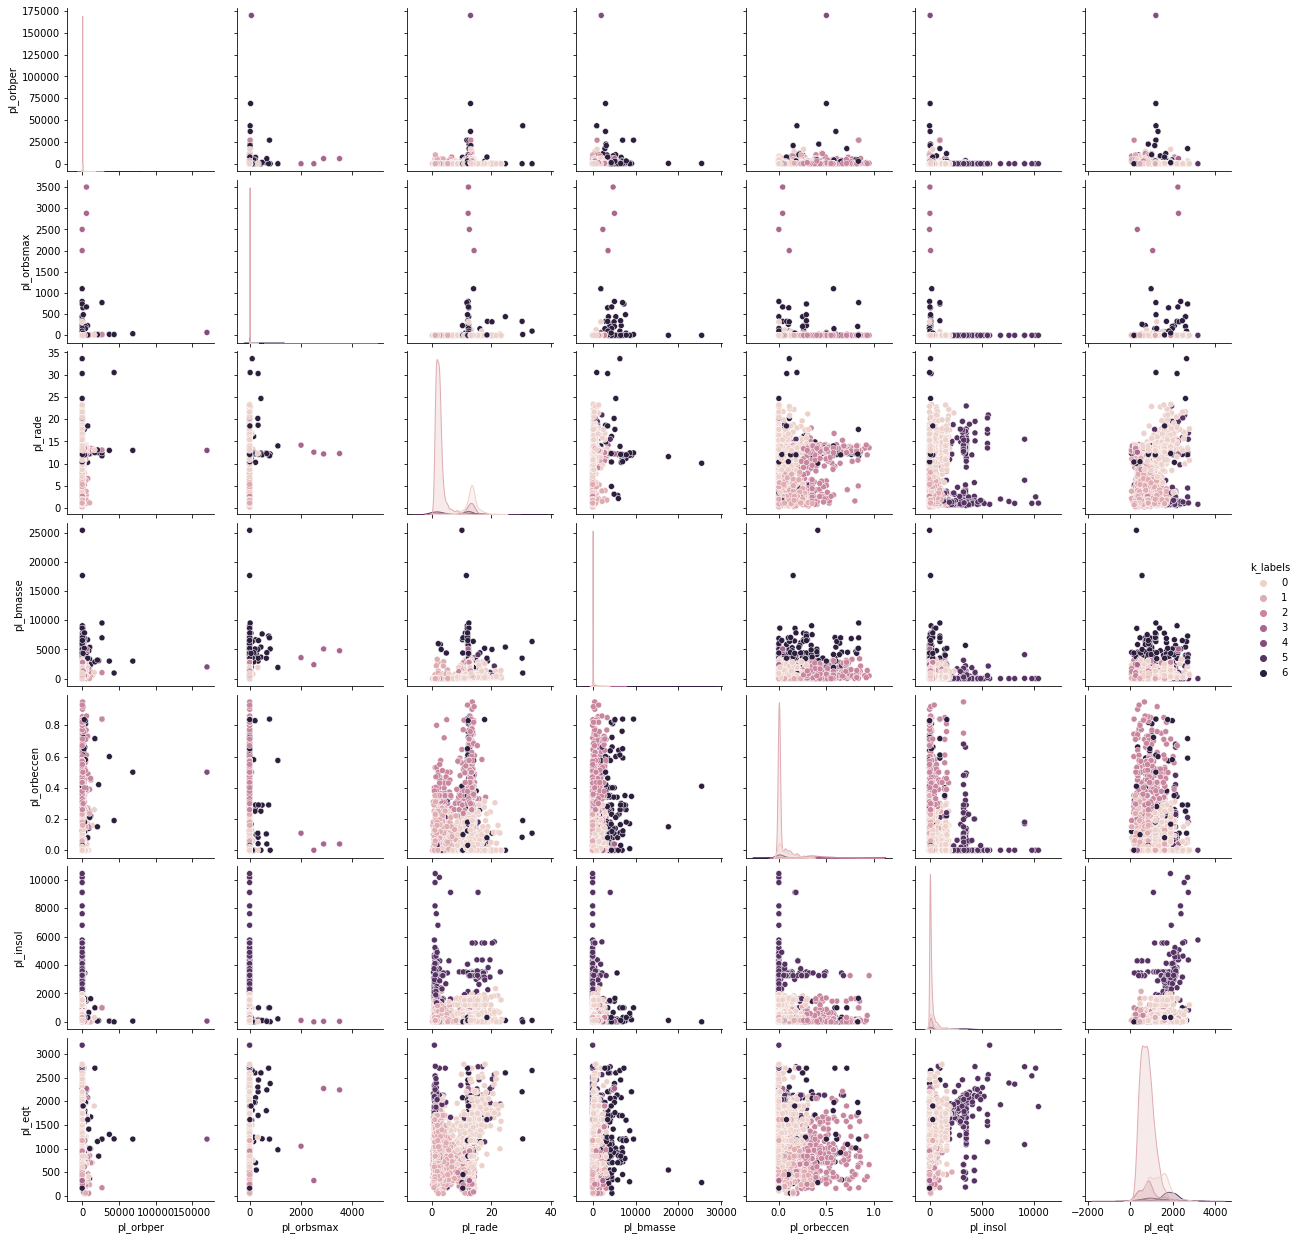

In [45]:
X = df.drop(columns = ['pl_name','hostname','disc_facility'])
sns.pairplot(data=X, hue = 'k_labels')


<AxesSubplot:xlabel='pl_bmasse', ylabel='pl_eqt'>

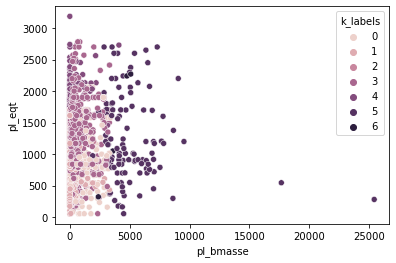

In [25]:
sns.scatterplot(x= df['pl_bmasse'], y = df['pl_eqt'], hue= df['k_labels'])


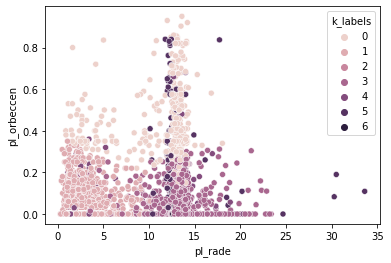

In [27]:
sns.scatterplot(x=df['pl_rade'], y = df['pl_orbeccen'], hue = df['k_labels']);

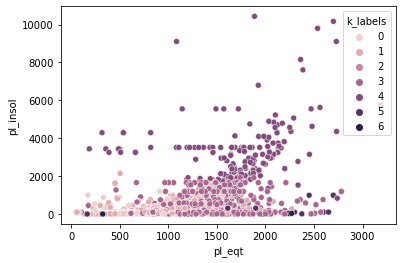

In [29]:
sns.scatterplot(x = df['pl_eqt'], y = df['pl_insol'], hue = df['k_labels']);

Just as I thought: these clusters are almost impossible to interpret.

In [46]:
df.to_csv('../datasets/clustered_data.csv')

# Conclusion
The 7 clusters created by my K-Means model are certainly not reflective of the official categories of exoplanets.  I cannot, in fact, discern what combination of mass, orbital period, size, and temperature led to the model's organization of these exoplanets.  As it stands, I do not think I can yet rely on this model to classify exoplanets in a novel and meaningful way.  Even with my very limited domain knowledge, I can understand that a classification system that is as imbalanced and opaque as this one is unreliable at best.  
If I were to pursue this model further, however, I would look to get more features for each exoplanet.  Many gas giants and neptunians are known to have certain elements in their atmospheres: I would want a breakdown of the amount of those elements in each exoplanet.  I would also seek out a way to organize this dataset into the already recognized 4 categories, and then apply a clustering model to each category, perhaps finding novel sub-classifications that could be useful in the future.  However, I currently cannot reject the null hypothesis of this experiment:  I cannot, with my current resources and available data, rely on machine learning to classify exoplanets in new and meaningful patterns.  